<h2><b>US Stock Portfolio

Portfolio Objectives:


1.   Screen through a list of potential US stocks, which has growth potential even or can hedge against risks even at market downturn. 
2.   Identify optimal buying strategy/ portfolio combination with efficient frontier optimization



In [ ]:
#import Python libraries
import pandas as pd
from pandas_datareader import data
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

!pip install PyPortfolioOpt
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import cla
from pypfopt import plotting

List of Stocks to be Examined:


*   GLD - SPDR Gold Trust (Physical Gold)
*   GDX - VanEck Vectors Gold Miners ETF 
*   SLV - iShares Silver Trust (Physical Silver)
*   PPLT - Aberdeen Standard Physical Platinum Shares ETF
*   PALL - Aberdeen Standard Physical Palladium Shares ETF
*   REMX - VanEck Vectors Rare Earth/Strategic Metals ETF
*   XME - SPDR S&P Metals and Mining ETF
*   DBA - Invesco DB Agriculture Fund (Commodities)
*   EWW - iShares Inc iShares MSCI Mexico (Emerging Markets)
*   INDA - iShares MSCI India (Emerging Markets)


<b>1) Historic Price & Daily Percentage Change in Given Period</b>

Scraping historic price and daily percentage change data from Yahoo Finance. In the same format, scrape the S&P 500, US Dollar Index and 10 Year US Treasury Note (yield data) for the same period.

In [221]:
#List of stocks to be examined
stocklist = ["GLD", "GDX", "SLV", "PPLT", "PALL", "REMX", "XME", "DBA", "EWW", "INDA", "^GSPC", "DX-Y.NYB", "^TNX"]

today = datetime.now().strftime("%Y-%m-%d")
start = "2020-01-01"
df=pd.DataFrame()

# retrieves daily closing price at the given period
for stock in stocklist:
  df[stock]= data.DataReader(stock, "yahoo", start, today)["Close"].round(2)

df.rename(columns={"^GSPC": "S&P500", "DX-Y.NYB": "USD Index", "^TNX": "10-yr T.Note"}, inplace=True)
df.head(3)

,GLD,GDX,SLV,PPLT,PALL,REMX,XME,DBA,EWW,INDA,S&P500,USD Index,10-yr T.Note
Date,,,,,,,,,,,,,
2020-01-02,143.95,29.35,16.81,92.35,184.41,41.34,29.16,16.50,46.26,35.58,3257.85,96.85,1.88
2020-01-03,145.86,29.17,16.84,92.36,187.33,41.25,28.90,16.31,45.92,34.98,3234.85,96.84,1.79
2020-01-06,147.39,29.22,16.94,90.68,190.86,41.64,28.63,16.35,46.13,34.57,3246.28,96.67,1.81


In [222]:
# retrievess daily percentage change of the stock list at the given period
returns = df.pct_change().round(4)
returns.head(3)

,GLD,GDX,SLV,PPLT,PALL,REMX,XME,DBA,EWW,INDA,S&P500,USD Index,10-yr T.Note
Date,,,,,,,,,,,,,
2020-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03,0.0133,-0.0061,0.0018,0.0001,0.0158,-0.0022,-0.0089,-0.0115,-0.0073,-0.0169,-0.0071,-0.0001,-0.0479
2020-01-06,0.0105,0.0017,0.0059,-0.0182,0.0188,0.0095,-0.0093,0.0025,0.0046,-0.0117,0.0035,-0.0018,0.0112


<b>2) Coorelation between Individual Stock against Benchmarks</b>

Coorelating each stock against S&P500/ US Dollar Index/ 10 Year US Treasury Note, to indicate relative (or potential) price movement should stock market changes direction/ US Dollars (against other currencies)/ US Treasury yield.

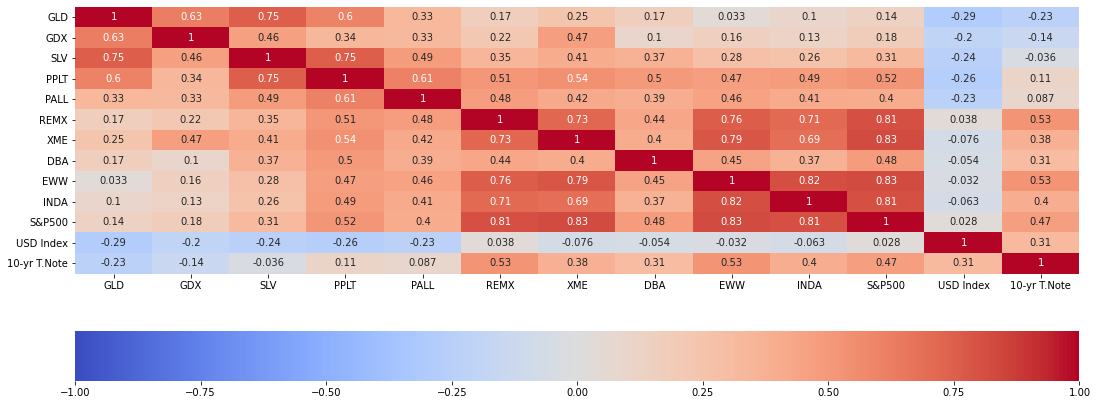

In [223]:
#correlatoin heatmap - individual stock against S&P 500/ US Dollar Index/ 10 Year US Treasury Notes
plt.figure(figsize=(18,7))
sns.heatmap(returns.corr(), annot = True, vmin=-1, vmax=1, center=0, cmap='coolwarm', cbar_kws= {'orientation': 'horizontal'})

Correlation heatmap on FANG Stock against S&P/ USD Index/ 10 Year Treasury Note for the same period

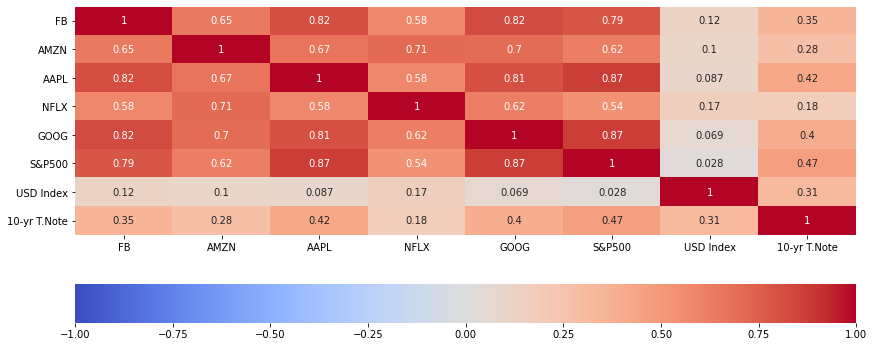

In [242]:
fanglist = ["FB", "AMZN", "AAPL", "NFLX", "GOOG", "^GSPC", "DX-Y.NYB", "^TNX"]
fang=pd.DataFrame()

for stock in fanglist:
  fang[stock]= data.DataReader(stock, "yahoo", start, today)["Close"].round(2)
fang.rename(columns={"^GSPC": "S&P500", "DX-Y.NYB": "USD Index", "^TNX": "10-yr T.Note"}, inplace=True)
fangreturns = fang.pct_change().round(4)
plt.figure(figsize=(14,6))
sns.heatmap(fangreturns.corr(), annot = True, vmin=-1, vmax=1, center=0, cmap='coolwarm', cbar_kws= {'orientation': 'horizontal'})

Calculate the expected return using the weighted mean of (daily) historical returns.

In [243]:
mu = expected_returns.mean_historical_return(df).to_frame().T
mu.round(3)

,GLD,GDX,SLV,PPLT,PALL,REMX,XME,DBA,EWW,INDA,S&P500,USD Index,10-yr T.Note
0,0.379,0.749,0.702,-0.013,0.336,0.172,-0.107,-0.211,-0.351,0.053,0.164,-0.055,-0.76


<b>3) Portfolio Building/ Optimization</b>

Assuming initially equal weights are being assigned to the entire stock list. Determine initial portfolio vairance and volatility

In [232]:
#List of stocks to be considered in a portfolio
buylist = ["GLD", "GDX", "SLV", "PPLT", "PALL", "REMX", "XME", "DBA", "EWW", "INDA"]
weight = np.array([0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1])

# retrieves daily closing price at the given period
bl=pd.DataFrame()

for stock in buylist:
  bl[stock]= data.DataReader(stock, "yahoo", start, today)["Close"].round(2)
bl_returns = bl.pct_change().round(4)

In [233]:
#calculating portfolio variance basd on stock buy list
cov_matrix_annual = bl_returns.cov()*253 #--> aveage nasdaq trading days
portfolio_variance = np.dot(weight.T, np.dot(cov_matrix_annual, weight))
portfolio_variance.round(4)

0.1139

In [234]:
#calculating portfolio volatility
portfolio_volatility = np.sqrt(portfolio_variance)
portfolio_volatility.round(4)

0.3376

Machine recommended portfolio weighting, based on the stock list provided. Portfolio optimized assuming maximum Sharp Ratio (i.e. maximizing risk adjusted returns against risk free assets)

In [245]:
mu = expected_returns.ema_historical_return(bl) 
s = risk_models.sample_cov(bl)
ef = EfficientFrontier(mu, s)
weight_ef = ef.max_sharpe()
clean_weights = ef.clean_weights()
clean_weights

OrderedDict([('GLD', 0.44672),
             ('GDX', 0.02382),
             ('SLV', 0.52946),
             ('PPLT', 0.0),
             ('PALL', 0.0),
             ('REMX', 0.0),
             ('XME', 0.0),
             ('DBA', 0.0),
             ('EWW', 0.0),
             ('INDA', 0.0)])

Calculating the Portfolio's Performance
<br>


In [236]:
ef.portfolio_performance(verbose=True)

Expected annual return: 67.6%
Annual volatility: 33.3%
Sharpe Ratio: 1.97


(0.6756059320923626, 0.33296870937769363, 1.9689715989159047)

General guidance in reading the Sharpe Ratio:
*   Greater than 1.0 - usually considered acceptable to good by investors
*   Greater than 2.0 - very good 
*   Greater than 3.0 - excellent

Plotting the Efficient Frontier of the Machine Optimized Portfolio

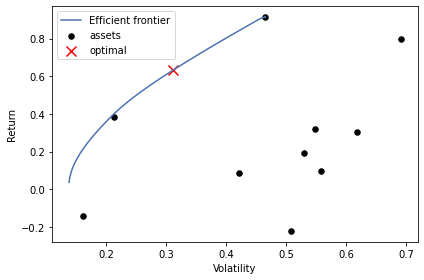

In [238]:
from pypfopt import cla
cla = cla.CLA(mu, s)
plotting.plot_efficient_frontier(cla, points=100, show_assets=True)

<b>4) Price Prediction on the Machine Recommended Portfolio

In [289]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('bmh')

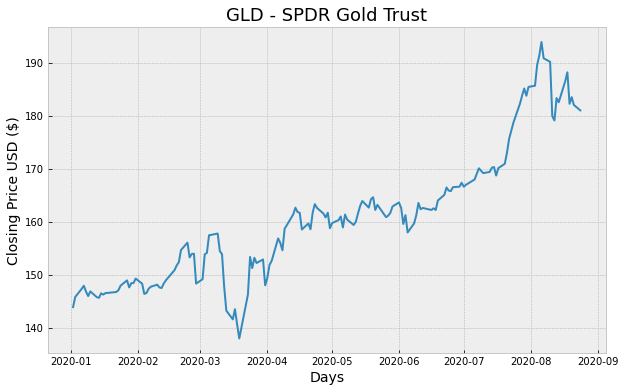

In [290]:
plt.figure(figsize=(10,6))
plt.title('GLD - SPDR Gold Trust', fontsize = 18)
plt.xlabel('Days', fontsize= 14)
plt.ylabel('Closing Price USD ($)', fontsize = 14)
plt.plot(bl['GLD'])
plt.show()

In [291]:
#predicting 30 days into the future
future_days = 30

bl['GLD Prediction'] = bl[["GLD"]].shift(-future_days)
GLD = bl[["GLD","GLD Prediction"]]

GLD.tail(3)

,GLD,GLD Prediction
Date,,
2020-08-20,183.50,NaN
2020-08-21,182.03,NaN
2020-08-24,181.00,NaN


In [292]:
#Split the data into 75% training and 25% testing data sets.
X = np.array(bl.drop(['GLD Prediction'], 1))[:-future_days]
y = np.array(bl['GLD Prediction'])[:-future_days]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [293]:
#Create the decision tree regressor model
tree = DecisionTreeRegressor().fit(x_train, y_train)
#Create the linear regression model
lr = LinearRegression().fit(x_train, y_train)

#Get all the rows from the original data set except the last 'x' days
x_future = bl.drop(['GLD Prediction'], 1)[:-future_days]
#Get the last 'x' rows
x_future = x_future.tail(future_days) 
#Convert the data set into a numpy array
x_future = np.array(x_future)

In [294]:
#Show the model tree prediction
#tree_prediction = tree.predict(x_future)
#Show the model linear regression prediction
#lr_prediction = lr.predict(x_future)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


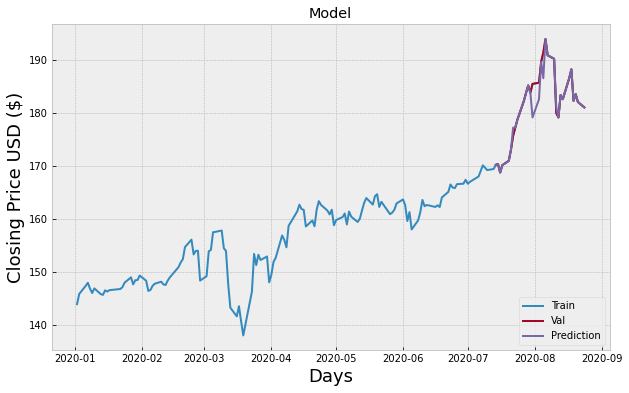

In [296]:
#Visualize the data
predictions = tree_prediction
#Plot the data
valid =  bl[X.shape[0]:]
valid['Predictions'] = predictions #Create a new column called 'Predictions' that will hold the predicted prices
plt.figure(figsize=(10,6))
plt.title('Model')
plt.xlabel('Days',fontsize=18)
plt.ylabel('Closing Price USD ($)',fontsize=18)
plt.plot(bl['GLD'])
plt.plot(valid[['GLD','Predictions']])
plt.legend(['Train', 'Val', 'Prediction' ], loc='lower right')
plt.show()